In [272]:
from pathlib import Path
from vesper.models.serialization import create_test_dataset, load_test_dataset
from vesper.models.variants import *
from vesper.models.reads import ReadGroup, AlignedRead
from vesper.models.interval import GenomicInterval
from vesper.models.repeatmasker import RepeatMaskerResult
from vesper.processors.vcf import VCFProcessor
from vesper.processors.reads import ReadProcessor

from vesper.analysis.breakpoint import *
from vesper.analysis.kmer import *

import numpy as np
import pandas as pd

import re
import os

import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib import font_manager
from matplotlib.transforms import Bbox
import seaborn as sns

# Single column width for most journals is ~3.5 inches
# Double column is ~7 inches
# Nature/Science are slightly different (~89mm and ~183mm)

SINGLE_COL_WIDTH = 3.5  # inches
DOUBLE_COL_WIDTH = 7.0  # inches
MAX_HEIGHT = 9.0  # typical max height for a full page

# Set consistent DPI for both display and saving
SAVE_DPI = 300  # publication quality
mpl.rcParams['figure.dpi'] = 150  # for display
mpl.rcParams['savefig.dpi'] = SAVE_DPI

# Set consistent font sizes that will look good at publication size
mpl.rcParams['font.size'] = 8  # base font size
mpl.rcParams['axes.titlesize'] = 9
mpl.rcParams['axes.labelsize'] = 8
mpl.rcParams['xtick.labelsize'] = 7
mpl.rcParams['ytick.labelsize'] = 7
mpl.rcParams['legend.fontsize'] = 7
mpl.rcParams['figure.titlesize'] = 10

# Set consistent line widths and marker sizes
mpl.rcParams['lines.linewidth'] = 1.0
mpl.rcParams['lines.markersize'] = 4
mpl.rcParams['axes.linewidth'] = 0.5

# save stock defaults for reference
default_font_family = plt.rcParams['font.family']
default_fonts = plt.rcParams['font.sans-serif'] 

# set default font 
font_path = '/System/Library/Fonts/HelveticaNeue.ttc'  # Your font path goes here
font_manager.fontManager.addfont(font_path)
prop = font_manager.FontProperties(fname=font_path)
plt.rcParams['font.sans-serif'] = prop.get_name()

# set figure save paths
figure_dir = "/Users/stacy/Documents/Writing/spermSV/Figures/plots"
supp_dir = "/Users/stacy/Documents/Writing/spermSV/Supplement/Figures"
if not os.path.exists(figure_dir):
    os.makedirs(figure_dir)
if not os.path.exists(supp_dir):
    os.makedirs(supp_dir)


In [ ]:
# only run with a new dataset to be saved
# with VCFProcessor(Path('/Users/stacy/sudmant/vesper/output/894.duplomap.annotated.refined.vcf.gz')) as vcf_proc, \
#     ReadProcessor(Path('/Users/stacy/sudmant/vesper/tests/files/hg38/894.duplomap.bam'), registry_dir=Path('/Users/stacy/sudmant/vesper/output/894.duplomap.annotated.refined.read_registry')) as read_proc:
specimens = ['5980', '898', '5619', '899', '895', '5621', 'ASD6058', 'TSC6830', 'TSC7237', 'N22T', 'RG6P', 'SY3L014', '0EL2', 'ASD6463', '0068', '894']

all_variants = []
for specimen in specimens:
    with VCFProcessor(Path(f'/Users/stacy/sudmant/vesper/output/qc_all/{specimen}/{specimen}.duplomap.qc_all.shared.annotated.refined.vcf.gz')) as vcf_proc, \
        ReadProcessor(Path(f'/Volumes/mnemosyne/spermSV/output/alignment/hg38/minimap2/duplomap/mapped/{specimen}/realigned.bam')) as read_proc:
        variants = list(vcf_proc.instantiate_variants())
        for variant in variants:
            support_reads, nonsupport_reads = read_proc.get_read_groups(variant.variant)
            variant.support_reads = support_reads
            variant.nonsupport_reads = nonsupport_reads
            variant._calculate_grouped_metrics()
            variant._calculate_confidence()
        specimen_variants = create_test_dataset(variants, Path(f"/Users/stacy/sudmant/vesper/notebooks/files/{specimen}_variants.pkl"), include_sequence=True)
        all_variants.extend(specimen_variants)
all_variants = create_test_dataset(all_variants, Path(f"/Users/stacy/sudmant/vesper/notebooks/files/all_variants.pkl"), include_sequence=True)

In [115]:
all_variants = load_test_dataset(Path("/Users/stacy/sudmant/vesper/notebooks/files/all_variants.pkl"))

In [47]:
BreakPointAnalyzer = BreakpointAnalyzer(reference_fasta = Path("/Users/stacy/sudmant/references/hg38_HGSVC/hg38.no_alt.fa"),
                                        context_size = 50,
                                        max_edit = 0,
                                        debug = True)

microhomology_data = []
tsd_data = []
poly_a_tail_data = []
read_data = []
for variant in all_variants:
    breakpoint = BreakPointAnalyzer.analyze_breakpoint(variant)
    repeat_class = variant.repeatmasker_results[0].repeat_class
    repeat_name = variant.repeatmasker_results[0].repeat_name
    if breakpoint.microhomology[0]:
        _, microhomology_sequence, microhomology_length, microhomology_coords = breakpoint.microhomology
        microhomology_entry = {
            'variant_id': variant.variant.ID,
            'repeat_class': repeat_class,
            'repeat_name': repeat_name,
            'microhomology_sequence': microhomology_sequence,
            'microhomology_length': microhomology_length,
            'microhomology_coords': microhomology_coords
        }
        microhomology_data.append(microhomology_entry)
    if breakpoint.tsd[0]:
        _, tsd_edit_distance, left_tsd_sequence, right_tsd_sequence, tsd_length, tsd_coords = breakpoint.tsd
        
        tsd_entry = {
            'variant_id': variant.variant.ID,
            'repeat_class': repeat_class,
            'repeat_name': repeat_name,
            'tsd_edit_distance': tsd_edit_distance,
            'left_tsd_sequence': left_tsd_sequence,
            'right_tsd_sequence': right_tsd_sequence,
            'tsd_length': tsd_length,
            'tsd_coords': tsd_coords # remember these are relative to the insertion
        }
        tsd_data.append(tsd_entry)
    if breakpoint.poly_a_tail[0]:
        _, poly_a_tail_seq, poly_a_tail_coords, poly_a_tail_length, poly_a_tail_impurity = breakpoint.poly_a_tail
        
        poly_a_tail_entry = {
            'variant_id': variant.variant.ID,
            'repeat_class': repeat_class,
            'repeat_name': repeat_name,
            'poly_a_tail_length': poly_a_tail_length,
            'poly_a_tail_coords': poly_a_tail_coords, # remember these are relative to the insertion
            'poly_a_tail_seq': poly_a_tail_seq,
            'poly_a_tail_impurity': poly_a_tail_impurity
        }
        poly_a_tail_data.append(poly_a_tail_entry)
    
    if breakpoint.support_reads:
        for read in breakpoint.support_reads.reads:
            read_entry = {
                'variant_id': variant.variant.ID,
                'read_id': read.name,
                'read_sequence': read.sequence
            }
            read_data.append(read_entry)

microhomology_df = pd.DataFrame(microhomology_data) # kind of broken rn leave for later
tsd_df = pd.DataFrame(tsd_data)
poly_a_tail_df = pd.DataFrame(poly_a_tail_data)
read_data_df = pd.DataFrame(read_data)

In [200]:
BreakPointAnalyzer = BreakpointAnalyzer(reference_fasta = Path("/Users/stacy/sudmant/references/hg38_HGSVC/hg38.no_alt.fa"),
                                        context_size = 50,
                                        max_edit = 0,
                                        debug = True)

def reverse_complement(sequence):
    """Return the reverse complement of a DNA sequence."""
    complement = {'A': 'T', 'T': 'A', 'C': 'G', 'G': 'C',
                 'a': 't', 't': 'a', 'c': 'g', 'g': 'c'}
    return ''.join(complement.get(base, base) for base in sequence[::-1])

def extract_alu_info(variant):
    """Extract Alu-related information from a variant."""
    rm_result = variant.repeatmasker_results[0]
    ins_seq = variant.variant.alt
    
    if rm_result.strand == 'C':
        ins_seq = reverse_complement(ins_seq)
        
    return {
        'repeat_name': rm_result.repeat_name,
        'ins_seq': ins_seq,
        'strand': rm_result.strand,
        'query_start': rm_result.query_start,
        'query_end': rm_result.query_end,
        'repeat_start': rm_result.repeat_start,
        'repeat_end': rm_result.repeat_end,
        'repeat_remaining': rm_result.repeat_left
    }

def create_alu_context_entry(breakpoint, alu_info):
    """Create a dictionary entry for Alu context information."""
    ins_seq = alu_info['ins_seq']
    query_start = alu_info['query_start']
    query_end = alu_info['query_end']
    
    return {
        'ins_name': alu_info['repeat_name'],
        'original_strand': alu_info['strand'],
        'left_ref_context': breakpoint.left_ref_context.upper(),
        'right_ref_context': breakpoint.right_ref_context.upper(),
        'poly_a_tail_seq': breakpoint.poly_a_tail[1],
        'poly_a_tail_start':  breakpoint.poly_a_tail[2][0],
        'poly_a_tail_end':  breakpoint.poly_a_tail[2][1],
        'poly_a_tail_length': breakpoint.poly_a_tail[3],
        'poly_a_tail_impurity': breakpoint.poly_a_tail[4],
        'left_tsd_seq': breakpoint.tsd[2],
        'right_tsd_seq': breakpoint.tsd[3],
        'tsd_edit_distance': breakpoint.tsd[1],
        'tsd_length': breakpoint.tsd[4],
        'left_tsd_start': breakpoint.tsd[5][0],
        'left_tsd_end': breakpoint.tsd[5][0] + breakpoint.tsd[4], 
        'right_tsd_start': len(ins_seq) + breakpoint.tsd[5][1], # adjust relative to the insertion seq
        'right_tsd_end': len(ins_seq) + breakpoint.tsd[5][1] + breakpoint.tsd[4], # adjust relative to the insertion seq
        'ins_seq': ins_seq.upper(),
        'ins_seq_length': len(ins_seq),
        'ins_query_start': query_start,
        'ins_query_end': query_end,
        'ins_pre_query': ins_seq[:query_start],
        'ins_match_seq': ins_seq[query_start:query_end],
        'ins_match_length': query_end - query_start,
        'ins_repeat_start': alu_info['repeat_start'],
        'ins_repeat_end': alu_info['repeat_end'],
        'ins_repeat_remaining': alu_info['repeat_remaining']
    }

alu_contexts = []
alu_reads = []
for variant in all_variants:
    if variant.repeatmasker_results[0].repeat_class == 'SINE/Alu':
        alu_info = extract_alu_info(variant)
        breakpoint = BreakPointAnalyzer.analyze_breakpoint(variant)

        context_entry = create_alu_context_entry(breakpoint, alu_info)
        if context_entry['original_strand'] == 'C':
            context_entry['ins_seq'] = reverse_complement(context_entry['ins_seq']) # match the sequence in the actual read
        context_entry['variant_id'] = variant.variant.ID
        alu_contexts.append(context_entry)

        for read in breakpoint.support_reads.reads:
            read_entry = {
                    'variant_id': variant.variant.ID,
                    'strand': alu_info['strand'],
                    'read_id': read.name,
                    'read_sequence': read.sequence
                }
            alu_reads.append(read_entry)

alu_contexts_df = pd.DataFrame(alu_contexts)
alu_reads_df = pd.DataFrame(alu_reads)
alu_contexts_df = pd.merge(alu_contexts_df, alu_reads_df, on = 'variant_id')

/var/folders/d1/_d4s2fqs7_z4dhbkbh6b02xw0000gn/T/ipykernel_94160/3117443474.py:34: UserWarning: Glyph 9650 (\N{BLACK UP-POINTING TRIANGLE}) missing from font(s) Helvetica Neue.
  plt.tight_layout()
/var/folders/d1/_d4s2fqs7_z4dhbkbh6b02xw0000gn/T/ipykernel_94160/3117443474.py:35: UserWarning: Glyph 9650 (\N{BLACK UP-POINTING TRIANGLE}) missing from font(s) Helvetica Neue.
  plt.savefig(f'{figure_dir}/text_test_{column_width}.pdf', dpi=300)
/var/folders/d1/_d4s2fqs7_z4dhbkbh6b02xw0000gn/T/ipykernel_94160/3117443474.py:35: UserWarning: Glyph 9650 (\N{BLACK UP-POINTING TRIANGLE}) missing from font(s) Helvetica Neue.
  plt.savefig(f'{figure_dir}/text_test_{column_width}.pdf', dpi=300)
/var/folders/d1/_d4s2fqs7_z4dhbkbh6b02xw0000gn/T/ipykernel_94160/3117443474.py:34: UserWarning: Glyph 9650 (\N{BLACK UP-POINTING TRIANGLE}) missing from font(s) Helvetica Neue.
  plt.tight_layout()
/var/folders/d1/_d4s2fqs7_z4dhbkbh6b02xw0000gn/T/ipykernel_94160/3117443474.py:35: UserWarning: Glyph 9650 (\N{B

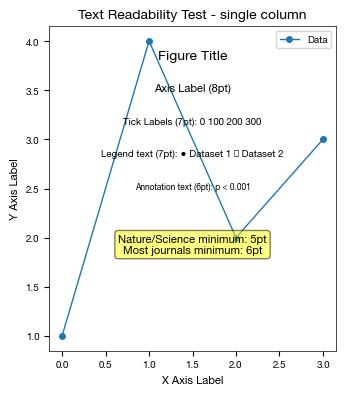

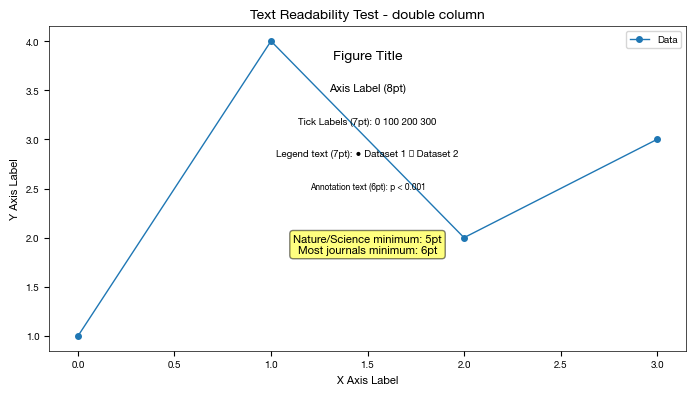

In [264]:
def create_text_test_figure(column_width='single'):
    """Create a figure to test text readability at publication size"""
    
    width = 3.5 if column_width == 'single' else 7.0
    
    fig, ax = plt.subplots(figsize=(width, 4), dpi=100)
    
    # Sample of typical figure elements at different font sizes
    test_elements = [
        (0.5, 0.9, 'Figure Title', 10, 'bold'),
        (0.5, 0.8, 'Axis Label (8pt)', 8, 'normal'),
        (0.5, 0.7, 'Tick Labels (7pt): 0 100 200 300', 7, 'normal'),
        (0.5, 0.6, 'Legend text (7pt): ● Dataset 1 ▲ Dataset 2', 7, 'normal'),
        (0.5, 0.5, 'Annotation text (6pt): p < 0.001', 6, 'normal'),
    ]
    
    for x, y, text, size, weight in test_elements:
        ax.text(x, y, text, transform=ax.transAxes, 
                fontsize=size, weight=weight, ha='center')
    
    # Add some sample data with typical line weights
    ax.plot([0, 1, 2, 3], [1, 4, 2, 3], 'o-', linewidth=1.0, 
            markersize=4, label='Data')
    ax.set_xlabel('X Axis Label', fontsize=8)
    ax.set_ylabel('Y Axis Label', fontsize=8)
    ax.set_title(f'Text Readability Test - {column_width} column', fontsize=10)
    ax.legend(fontsize=7)
    
    # Add minimum size warning
    ax.text(0.5, 0.3, 'Nature/Science minimum: 5pt\nMost journals minimum: 6pt', 
            transform=ax.transAxes, fontsize=8, ha='center', 
            bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.5))
    
    plt.tight_layout()
    plt.savefig(f'{figure_dir}/text_test_{column_width}.pdf', dpi=300)
    return fig

# Create test figures
fig_single = create_text_test_figure('single')
fig_double = create_text_test_figure('double')

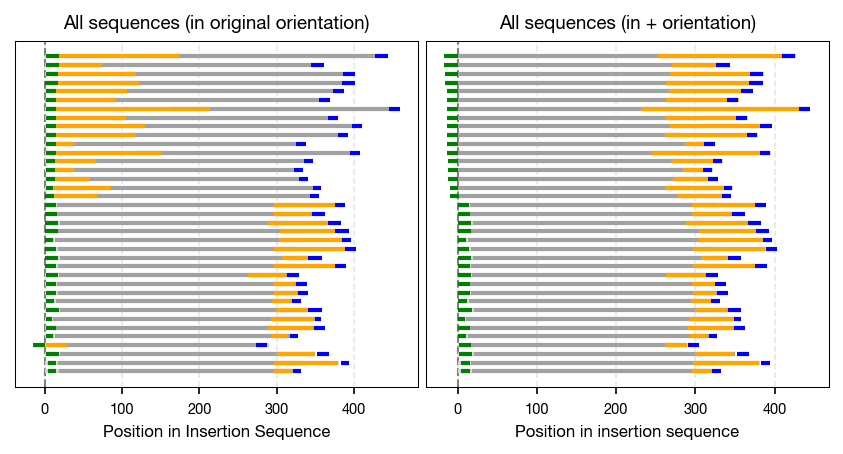

In [312]:
original_df = alu_contexts_df.copy()
viz_df = alu_contexts_df.copy()

for idx, row in viz_df.iterrows():
    if row['original_strand'] == 'C':
        seq_len = row['ins_seq_length']
        
        # flip query/alu match coords
        viz_df.loc[idx, 'viz_ins_query_start'] = seq_len - row['ins_query_end']
        viz_df.loc[idx, 'viz_ins_query_end'] = seq_len - row['ins_query_start']
        
        # flip Poly(A) coords
        viz_df.loc[idx, 'viz_poly_a_tail_start'] = seq_len - row['poly_a_tail_end']
        viz_df.loc[idx, 'viz_poly_a_tail_end'] = seq_len - row['poly_a_tail_start']
        
        # flip + swap (left <-> right) TSD coords
        viz_df.loc[idx, 'viz_left_tsd_start'] = seq_len - row['right_tsd_end']
        viz_df.loc[idx, 'viz_left_tsd_end'] = seq_len - row['right_tsd_start']
        viz_df.loc[idx, 'viz_right_tsd_start'] = seq_len - row['left_tsd_end']
        viz_df.loc[idx, 'viz_right_tsd_end'] = seq_len - row['left_tsd_start']
        
    else:
        viz_df.loc[idx, 'viz_ins_query_start'] = row['ins_query_start']
        viz_df.loc[idx, 'viz_ins_query_end'] = row['ins_query_end']
        viz_df.loc[idx, 'viz_poly_a_tail_start'] = row['poly_a_tail_start']
        viz_df.loc[idx, 'viz_poly_a_tail_end'] = row['poly_a_tail_end']
        viz_df.loc[idx, 'viz_left_tsd_start'] = row['left_tsd_start']
        viz_df.loc[idx, 'viz_left_tsd_end'] = row['left_tsd_end']
        viz_df.loc[idx, 'viz_right_tsd_start'] = row['right_tsd_start']
        viz_df.loc[idx, 'viz_right_tsd_end'] = row['right_tsd_end']

sorted_viz_df = viz_df.sort_values(['viz_left_tsd_start', 'original_strand'], 
                                   ascending=[False, True])
original_df = original_df.loc[sorted_viz_df.index] # make comparable

fig, ax = plt.subplots(1, 2, figsize=(DOUBLE_COL_WIDTH, 3), gridspec_kw={'wspace': 0.02})

ax[0].axvline(x=0, color='grey', linestyle='--')

for i, (_, row) in enumerate(original_df.iterrows()):
    ax[0].hlines(y=i, xmin=0, xmax=row.ins_seq_length,
              linewidth=2, color='lightgray')
    ax[0].hlines(y=i, xmin=row.ins_query_start, xmax=row.ins_query_end,
              linewidth=2, color='gray', alpha=0.6)
    ax[0].hlines(y=i, xmin=row.poly_a_tail_start, xmax=row.poly_a_tail_end,
              linewidth=2, color='orange')
    ax[0].hlines(y=i, xmin=row.left_tsd_start, xmax=row.left_tsd_end,
              linewidth=2, color='green')
    ax[0].hlines(y=i, xmin=row.right_tsd_start, xmax=row.right_tsd_end,
              linewidth=2, color='blue')
    
# Uncomment to show the strand labels
# ax[0].set_yticks(range(len(original_df)))
# ax[0].set_yticklabels([f"{row.original_strand}" for _, row in original_df.iterrows()])

ax[0].set_yticks([])
ax[0].set_xlabel('Position in Insertion Sequence')
ax[0].grid(True, alpha=0.3, linestyle='--')
ax[0].set_title('All sequences (in original orientation)')

ax[1].axvline(x=0, color='grey', linestyle='--')

for i, (_, row) in enumerate(sorted_viz_df.iterrows()):
    ax[1].hlines(y=i, xmin=0, xmax=row.ins_seq_length,
              linewidth=2, color='lightgray')
    ax[1].hlines(y=i, xmin=row.viz_ins_query_start, xmax=row.viz_ins_query_end,
              linewidth=2, color='gray', alpha=0.6)
    ax[1].hlines(y=i, xmin=row.viz_poly_a_tail_start, xmax=row.viz_poly_a_tail_end,
              linewidth=2, color='orange')
    ax[1].hlines(y=i, xmin=row.viz_left_tsd_start, xmax=row.viz_left_tsd_end,
              linewidth=2, color='green')
    ax[1].hlines(y=i, xmin=row.viz_right_tsd_start, xmax=row.viz_right_tsd_end,
              linewidth=2, color='blue')
    
# Uncomment to show the strand labels
# ax[1].set_yticks(range(len(sorted_viz_df)))
# ax[1].set_yticklabels([f"{row.original_strand}" for _, row in sorted_viz_df.iterrows()])

ax[1].set_yticks([])
ax[1].set_xlabel('Position in insertion sequence')
ax[1].grid(True, alpha=0.3, linestyle='--')
ax[1].set_title('All sequences (in + orientation)')

plt.savefig(f'{supp_dir}/alu_context_viz.png', 
            transparent = True,
            dpi=300)
plt.savefig(f'{supp_dir}/alu_context_viz.pdf',
            bbox_inches = Bbox([[0.65,-0.2],[DOUBLE_COL_WIDTH-0.5, 3]]),
            transparent = True)

/var/folders/d1/_d4s2fqs7_z4dhbkbh6b02xw0000gn/T/ipykernel_94160/299000682.py:5: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  plt.axvspan(xmin=280, xmax=310, alpha=0.4, color='lightgray',


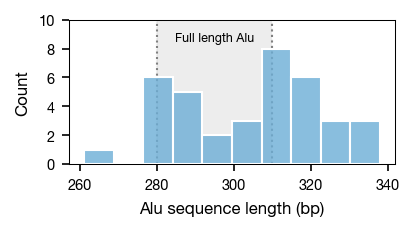

In [308]:
# Length of insertion sequence identified as Alu

plt.figure(figsize=(SINGLE_COL_WIDTH/1.25, 1.25))

plt.axvspan(xmin=280, xmax=310, alpha=0.4, color='lightgray',
            edgecolor = 'darkgray', linestyle = 'dotted', 
            zorder = 2)
plt.axvline(x = 280, color = 'gray', linestyle = 'dotted')
plt.axvline(x = 310, color = 'gray', linestyle = 'dotted')
plt.text(x=295, y=8.75, s='Full length Alu', ha='center', va='center', fontsize = 6, fontweight = 600)

sns.histplot(data=alu_contexts_df, x='ins_match_length',
             bins = 10,
             color = '#6caed6',
             edgecolor = 'white',
             alpha = 0.8,
             zorder = 3)

plt.ylabel('Count')
plt.ylim(0, 10)
plt.yticks(range(0, 11, 2))
plt.xlabel('Alu sequence length (bp)')

plt.savefig(f"{figure_dir}/alu_length_hist.png", 
            transparent = True,
            dpi = 300)
plt.savefig(f"{figure_dir}/alu_length_hist.pdf",
            bbox_inches = Bbox([[-0.1, -0.25],[SINGLE_COL_WIDTH/1.25-0.1,1.25]]),
            transparent = True)

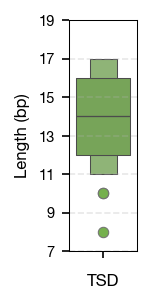

In [ ]:
# Length of TSDs and Poly(A) tail
fig, ax = plt.subplots(1,1, figsize=(SINGLE_COL_WIDTH/6, 2))

# left plot - TSD length distribution
ax.grid(True, linestyle='--', alpha=0.3)
sns.boxenplot(ax=ax, data=alu_contexts_df, y='tsd_length', color = '#75b04d', alpha = 1,
              flier_kws=dict(facecolor="#75b04d", linewidth=.5))
ax.set_ylabel('Length (bp)')
ax.set_xlabel('TSD')
ax.tick_params(axis='x', rotation=45)
ax.set_yticks(range(7, 20, 2))

plt.savefig(f"{figure_dir}/tsd_length_dist.png", 
            transparent = True,
            bbox_inches = Bbox([[-0.35, -0.15],[SINGLE_COL_WIDTH/6,1.9]]),
            dpi = 300)
plt.savefig(f"{figure_dir}/tsd_length_dist.pdf",
            bbox_inches = Bbox([[-0.35, -0.15],[SINGLE_COL_WIDTH/6,1.9]]),
            transparent = True)

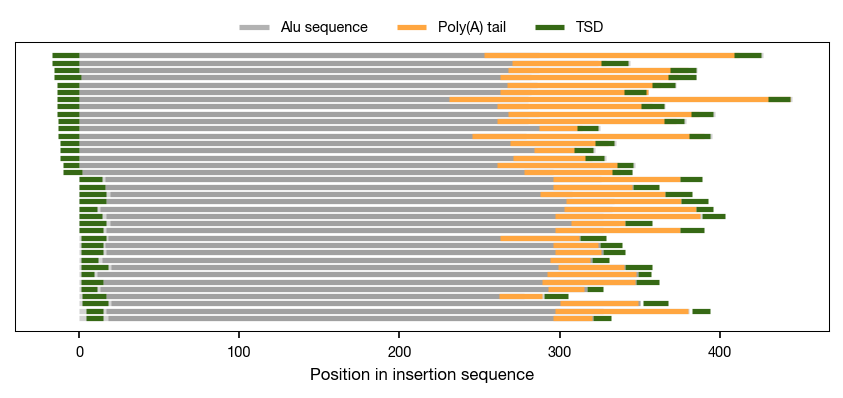

In [290]:
fig, ax = plt.subplots(figsize=(DOUBLE_COL_WIDTH,2.5))

for i, (_, row) in enumerate(sorted_viz_df.iterrows()):
    ax.hlines(y=i, xmin=0, xmax=row.ins_seq_length,
              linewidth=2.5, color='lightgray')
    ax.hlines(y=i, xmin=row.viz_ins_query_start, xmax=row.viz_ins_query_end,
              linewidth=2.5, color='gray', alpha=0.6, label='Alu sequence' if i == 0 else "")
    ax.hlines(y=i, xmin=row.viz_poly_a_tail_start, xmax=row.viz_poly_a_tail_end,
              linewidth=2.5, color='#ffa640', label='Poly(A) tail' if i == 0 else "")
    # label TSDs with same color now that orientation is confirmed
    ax.hlines(y=i, xmin=row.viz_left_tsd_start, xmax=row.viz_left_tsd_end,
              linewidth=2.5, color='#366915', label='TSD' if i == 0 else "")
    ax.hlines(y=i, xmin=row.viz_right_tsd_start, xmax=row.viz_right_tsd_end,
              linewidth=2.5, color='#366915')


ax.set_yticks([])
ax.set_xlabel('Position in insertion sequence')
ax.tick_params(axis='x')
ax.legend(bbox_to_anchor=(0.5,1.12), ncol=4, loc='upper center', frameon=False)

plt.savefig(f"{figure_dir}/alu_profiles.png",
            transparent = True,
            bbox_inches = Bbox([[0.75,-0.15],[DOUBLE_COL_WIDTH-0.6, 2.45]]),
            dpi = 300)
plt.savefig(f"{figure_dir}/alu_profiles.pdf",
            bbox_inches = Bbox([[0.75,-0.15],[DOUBLE_COL_WIDTH-0.6, 2.45]]),
            transparent = True)

/var/folders/d1/_d4s2fqs7_z4dhbkbh6b02xw0000gn/T/ipykernel_94160/2831244943.py:22: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels(labels)


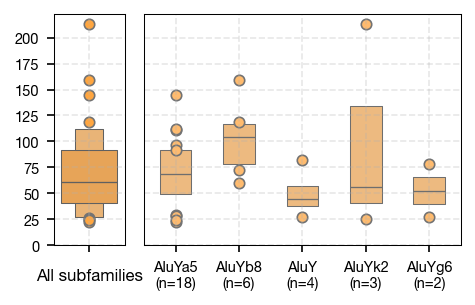

In [278]:
# Length of TSDs and Poly(A) tail
fig, axes = plt.subplots(1,2, figsize=(SINGLE_COL_WIDTH, 2), gridspec_kw={'width_ratios': [1, 4.5], 'wspace': 0.1})

# left plot - Poly(A) tail length distribution
sns.boxenplot(ax=axes[0], data=alu_contexts_df, y='poly_a_tail_length', color = '#ffa640',
              flier_kws=dict(facecolor="#ffa640", linewidth=.8))
axes[0].set_ylabel('')
axes[0].set_xlabel('All subfamilies')
axes[0].tick_params(axis='x', rotation=45)
axes[0].grid(True, linestyle='--', alpha=0.3)
axes[0].set_yticks(range(0, alu_contexts_df['poly_a_tail_length'].max()+1, 25))

# Get sample sizes for each subfamily
sample_sizes = alu_contexts_df['ins_name'].value_counts()
order = ['AluYa5', 'AluYb8', 'AluY', 'AluYk2', 'AluYg6']
labels = [f'{subfamily}\n(n={sample_sizes[subfamily]})' for subfamily in order]

sns.boxenplot(ax = axes[1], data=alu_contexts_df, x='ins_name', y='poly_a_tail_length', color = '#ffbb6e', order=order, width = 0.5,
              flier_kws=dict(facecolor="#ffbb6e", linewidth=.8))
# sns.boxenplot(ax = ax[1], data=sorted_ins_coords, x='ins_name', y='poly_a_tail_length', color = '#ffbb6e', order=order)
axes[1].grid(True, alpha=0.3, linestyle='--')
axes[1].set_xticklabels(labels)
axes[1].set_xlabel('')
axes[1].set_ylabel('')
axes[1].set_yticks(range(0, alu_contexts_df['poly_a_tail_length'].max()+1, 25), labels = [])
axes[1].tick_params(axis='y', length=0)  # Remove y tick mark


plt.savefig(f"{figure_dir}/poly_a_breakdown.png", 
            dpi = 300,
            bbox_inches = Bbox([[0,-0.25],[SINGLE_COL_WIDTH, 2]]),
            transparent = True)
plt.savefig(f"{figure_dir}/poly_a_breakdown.pdf",
            bbox_inches = Bbox([[0,-0.25],[SINGLE_COL_WIDTH, 2]]),
            transparent = True)


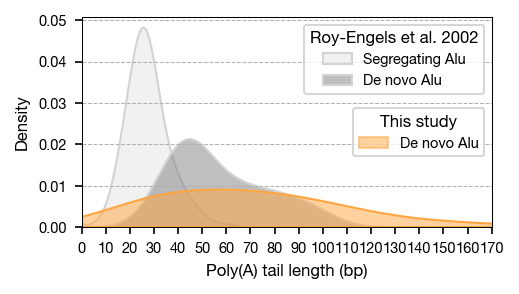

In [270]:
# Data from Roy-Engel et al. 2002, Genome Research
roy_engel_aluya5_counts = {
    3: 1,
    11: 2, 14: 2, 15: 5, 16: 7, 17: 6, 18: 5, 19: 5,
    20: 10, 21: 11, 22: 8, 23: 12, 24: 10, 25: 22, 26: 14, 27: 23, 28: 9, 29: 7,
    30: 9, 31: 13, 32: 0, 33: 7, 34: 6, 35: 5, 36: 3, 37: 3, 38: 2, 39: 5, 
    40: 0, 41: 3, 42: 0, 42: 3, 43: 3, 44: 3, 45: 0, 47: 3, 50: 3, 59: 2
}

roy_engel_alu_disease_counts = {
    39: 1, 40: 2, 41: 1, 42: 1, 43: 1, 44: 1, 45: 0, 46: 1, 48: 1, 49: 1, 
    62: 1, 64: 1, 68: 1, 80: 1, 78: 1, 91: 1, 96: 1
}

roy_engel_aluya5_counts = pd.DataFrame.from_dict(roy_engel_aluya5_counts, orient='index').reset_index()
roy_engel_aluya5_counts.columns = ['poly_a_tail_length', 'count']
roy_engel_aluya5_counts['percentage'] = roy_engel_aluya5_counts['count'] / roy_engel_aluya5_counts['count'].sum()

roy_engel_alu_disease_counts = pd.DataFrame.from_dict(roy_engel_alu_disease_counts, orient='index').reset_index()
roy_engel_alu_disease_counts.columns = ['poly_a_tail_length', 'count']
roy_engel_alu_disease_counts['percentage'] = roy_engel_alu_disease_counts['count'] / roy_engel_alu_disease_counts['count'].sum()

# only AluYa5
# aluya5_counts = alu_contexts_df[alu_contexts_df['ins_name'] == 'AluYa5']['poly_a_tail_length'].value_counts().to_frame().reset_index()
# aluya5_counts['percentage'] = aluya5_counts['count'] / aluya5_counts['count'].sum()
alu_tail_counts = alu_contexts_df['poly_a_tail_length'].value_counts().to_frame().reset_index()
alu_tail_counts['percentage'] = alu_tail_counts['count'] / alu_tail_counts['count'].sum()


fig = plt.figure(figsize=(SINGLE_COL_WIDTH,2))

sns.kdeplot(data=roy_engel_aluya5_counts, x='poly_a_tail_length', weights='percentage', 
            fill=True, alpha = 0.3, color='lightgray', label='Segregating Alu')
sns.kdeplot(data=roy_engel_alu_disease_counts, x='poly_a_tail_length', weights='percentage', 
            fill=True, alpha = 0.5, color='gray', edgecolor='lightgray', label='De novo Alu')

# label='De novo Alu\n(this study)',
sns.kdeplot(data=alu_tail_counts, x='poly_a_tail_length', weights='percentage', 
            fill=True, alpha = 0.5, color='#ffa640', legend = False)


plt.xlabel("Poly(A) tail length (bp)")
plt.ylabel("Density")
plt.grid(axis='y', linestyle='--', linewidth=0.5)
plt.xlim(0, 170)
plt.xticks(range(0, 171, 10))
plt.tight_layout()

# Create main legend
legend1 = plt.legend(title = "Roy-Engels et al. 2002", loc='upper right')

# Create patch for second legend
patch = Patch(color='#ffa640', alpha=0.5, label='De novo Alu')
# Add second legend below first one
plt.legend(title = "This study", handles=[patch], loc='upper right', bbox_to_anchor=(1.0, 0.6))
# Add the first legend back
plt.gca().add_artist(legend1)

plt.savefig(f"{figure_dir}/roy_engels_poly_a_comparison.png", 
            dpi = 300,
            transparent = True)
plt.savefig(f"{figure_dir}/roy_engels_poly_a_comparison.pdf",
            transparent = True)